In [22]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

# Add data_utils to path
sys.path.append(os.path.abspath('../data_utils'))
try:
    import util_minimal
    print("Successfully imported util_minimal")
except ImportError:
    print("Could not import util_minimal")

# Try to import backtester package
try:
    sys.path.append(os.path.abspath('../../'))
    from backtester import get_price_data
    print("Successfully imported backtester.get_price_data")
except ImportError:
    print("Could not import backtester")

Successfully imported util_minimal
Successfully imported backtester.get_price_data


In [23]:
# Define products we need
products = ['PICNIC_BASKET1', 'PICNIC_BASKET2', 'CROISSANTS', 'JAMS', 'DJEMBES']
product_data = {product: pd.DataFrame() for product in products}

# Try to load data using backtester package
has_data = False
try:
    for product in products:
        print(f"Loading {product} data using backtester...")
        product_data[product] = get_price_data(product, 2)
        print(f"Loaded {len(product_data[product])} rows of {product} data")
    has_data = all(len(data) > 0 for data in product_data.values())
    if has_data:
        print("Successfully loaded all required data using backtester")
except Exception as e:
    print(f"Error loading data using backtester: {e}")
    has_data = False

# If backtester package didn't work, try using util module
if not has_data:
    print("Trying to load data using util module...")
    try:
        reload(util_minimal)
        dm2p = util_minimal.load_all_price_data(2)
        print(f"Loaded {len(dm2p)} rows of data")
        
        # Display the first few rows
        print("\nFirst few rows of data:")
        display(dm2p.head())
        
        # Filter for each product
        for product in products:
            if product in dm2p['product'].unique():
                product_data[product] = dm2p[dm2p['product'] == product].copy()
                print(f"Filtered {len(product_data[product])} rows of {product} data")
            else:
                print(f"No {product} data found")
                product_data[product] = pd.DataFrame()
        
        has_data = all(len(data) > 0 for data in product_data.values())
        if has_data:
            print("Successfully loaded all required data using util module")
    except Exception as e:
        print(f"Error loading data using util module: {e}")
        has_data = False

Loading PICNIC_BASKET1 data using backtester...
Loading real data for PICNIC_BASKET1 from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_0.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_1.csv
Successfully loaded real data with 30000 rows
Loaded 30000 rows of PICNIC_BASKET1 data
Loading PICNIC_BASKET2 data using backtester...
Loading real data for PICNIC_BASKET2 from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_0.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_1.csv
Successfully loaded real data with 30000 rows
Loaded 30000 rows of PICNIC_BASKET2 data
Loading CROISSANTS data using backtester...
Loading real

In [24]:
# Function to calculate VWAP for all products
def calculate_vwap(product_data):
    vwap_prices = {}
    for product, data in product_data.items():
        if len(data) > 0:
            try:
                # Try to use get_vwap from util_minimal if available
                vwap = util_minimal.get_vwap(data, product)
                vwap_prices[product] = vwap
                print(f"Calculated VWAP for {product} using util_minimal.get_vwap")
            except Exception as e:
                print(f"Error using util_minimal.get_vwap for {product}: {e}")
                
                # Calculate VWAP manually
                try:
                    # Calculate mid price if not already present
                    if 'mid_price' not in data.columns:
                        data['mid_price'] = (data['ask_price_1'] + data['bid_price_1']) / 2
                    
                    # Calculate volume if not already present
                    if 'total_volume' not in data.columns:
                        volume_cols = ['ask_volume_1', 'ask_volume_2', 'ask_volume_3', 'bid_volume_1', 'bid_volume_2', 'bid_volume_3']
                        data['total_volume'] = data[volume_cols].sum(axis=1)
                    
                    # Calculate VWAP
                    data['price_volume'] = data['mid_price'] * data['total_volume']
                    
                    # Group by timestamp if available, otherwise use index
                    if 'timestamp' in data.columns:
                        data_grouped = data.groupby('timestamp')
                        vwap = data_grouped['price_volume'].sum() / data_grouped['total_volume'].sum()
                    else:
                        data_grouped = data.groupby(data.index)
                        vwap = data_grouped['price_volume'].sum() / data_grouped['total_volume'].sum()
                    
                    vwap_prices[product] = vwap
                    print(f"Calculated VWAP for {product} manually")
                except Exception as e:
                    print(f"Error calculating manual VWAP for {product}: {e}")
                    
                    # Fall back to mid price if VWAP calculation fails
                    if 'mid_price' in data.columns:
                        if 'timestamp' in data.columns:
                            vwap_prices[product] = data.set_index('timestamp')['mid_price']
                        else:
                            vwap_prices[product] = data['mid_price']
                        print(f"Falling back to mid price for {product}")
    
    return vwap_prices

# Function to prepare price data for spread calculation
def prepare_price_data(vwap_prices):
    # Create a common index for all products
    all_indices = set()
    for product, prices in vwap_prices.items():
        all_indices.update(prices.index)
    common_index = sorted(all_indices)
    
    # Reindex all price series to the common index and forward fill missing values
    reindexed_prices = {}
    for product, prices in vwap_prices.items():
        reindexed_prices[product] = prices.reindex(common_index).ffill().bfill()
    
    return reindexed_prices, common_index

# Calculate VWAP and prepare data
if has_data:
    try:
        # Calculate VWAP
        vwap_prices = calculate_vwap(product_data)
        print(f"Calculated VWAP for {len(vwap_prices)} products")
        
        # Prepare price data
        reindexed_prices, common_index = prepare_price_data(vwap_prices)
        print(f"Prepared price data with {len(common_index)} timestamps")
        
        # Check if we have all required products
        required_products = ['PICNIC_BASKET1', 'PICNIC_BASKET2', 'CROISSANTS', 'JAMS', 'DJEMBES']
        missing = [p for p in required_products if p not in reindexed_prices]
        
        if missing:
            print(f"Missing prices for: {', '.join(missing)}")
        else:
            print("All required products are available for spread calculation")
    except Exception as e:
        print(f"Error preparing data: {e}")
else:
    print("Cannot prepare data due to missing price data")

Calculated VWAP for PICNIC_BASKET1 using util_minimal.get_vwap
Calculated VWAP for PICNIC_BASKET2 using util_minimal.get_vwap
Calculated VWAP for CROISSANTS using util_minimal.get_vwap
Calculated VWAP for JAMS using util_minimal.get_vwap
Calculated VWAP for DJEMBES using util_minimal.get_vwap
Calculated VWAP for 5 products
Prepared price data with 30000 timestamps
All required products are available for spread calculation



Spread statistics:

pb1_spread:
Mean: 48.76
Median: 50.86
Min: -194.83
Max: 248.47
Standard deviation: 85.10

pb2_spread:
Mean: 30.24
Median: 38.50
Min: -120.74
Max: 148.76
Standard deviation: 59.84

First few rows of spread DataFrame:


,pb1_spread,pb2_spread,pb1_price,pb2_price,theoretical_pb1,theoretical_pb2
timestamp,,,,,,
0,0.236842,50.000000,59289.236842,30609.000000,59289.000000,30559.0
100,-1.027027,53.729730,59287.472973,30612.729730,59288.500000,30559.0
200,3.303922,54.696970,59293.500000,30614.696970,59290.196078,30560.0
300,0.500000,58.302326,59293.500000,30620.302326,59293.000000,30562.0
400,-9.720588,56.312500,59291.779412,30622.312500,59301.500000,30566.0


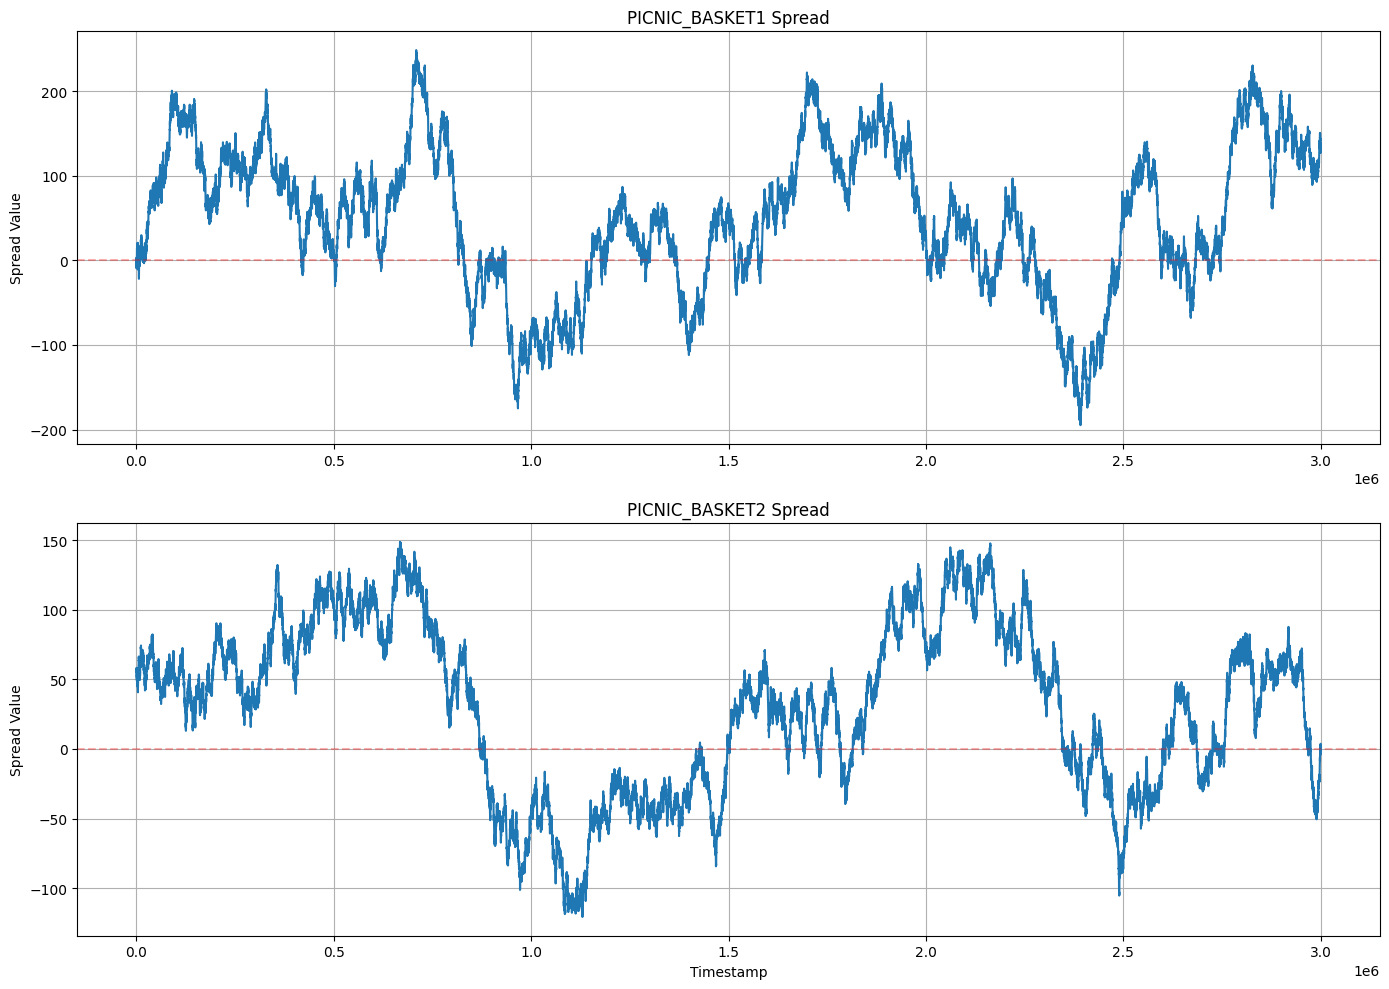

In [25]:
# Calculate spreads
if 'reindexed_prices' in locals() and all(p in reindexed_prices for p in ['PICNIC_BASKET1', 'PICNIC_BASKET2', 'CROISSANTS', 'JAMS', 'DJEMBES']):
    try:
        # Calculate theoretical basket values
        # PICNIC_BASKET1 = 6 × CROISSANTS + 3 × JAMS + 1 × DJEMBE
        theoretical_pb1 = (
            6 * reindexed_prices['CROISSANTS'] + 
            3 * reindexed_prices['JAMS'] + 
            1 * reindexed_prices['DJEMBES']
        )
        
        # PICNIC_BASKET2 = 4 × CROISSANTS + 2 × JAMS
        theoretical_pb2 = (
            4 * reindexed_prices['CROISSANTS'] + 
            2 * reindexed_prices['JAMS']
        )
        
        # Calculate spreads
        spreads = {}
        
        # 1. PICNIC_BASKET1 - base_assets
        spreads['pb1_spread'] = reindexed_prices['PICNIC_BASKET1'] - theoretical_pb1
        
        # 2. PICNIC_BASKET2 - base_assets
        spreads['pb2_spread'] = reindexed_prices['PICNIC_BASKET2'] - theoretical_pb2
        
        # Create a DataFrame with spreads
        spread_df = pd.DataFrame({
            'pb1_spread': spreads['pb1_spread'],
            'pb2_spread': spreads['pb2_spread'],
            'pb1_price': reindexed_prices['PICNIC_BASKET1'],
            'pb2_price': reindexed_prices['PICNIC_BASKET2'],
            'theoretical_pb1': theoretical_pb1,
            'theoretical_pb2': theoretical_pb2
        })
        
        # Display basic information about the spreads
        print("\nSpread statistics:")
        for name, spread in spreads.items():
            print(f"\n{name}:")
            print(f"Mean: {spread.mean():.2f}")
            print(f"Median: {spread.median():.2f}")
            print(f"Min: {spread.min():.2f}")
            print(f"Max: {spread.max():.2f}")
            print(f"Standard deviation: {spread.std():.2f}")
        
        # Display the first few rows of the spread DataFrame
        print("\nFirst few rows of spread DataFrame:")
        display(spread_df.head())
        
        # Plot the spreads
        plt.figure(figsize=(14, 10))
        
        # Plot PB1 spread
        plt.subplot(2, 1, 1)
        plt.plot(spread_df.index, spread_df['pb1_spread'])
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
        plt.title('PICNIC_BASKET1 Spread')
        plt.ylabel('Spread Value')
        plt.grid(True)
        
        # Plot PB2 spread
        plt.subplot(2, 1, 2)
        plt.plot(spread_df.index, spread_df['pb2_spread'])
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
        plt.title('PICNIC_BASKET2 Spread')
        plt.xlabel('Timestamp')
        plt.ylabel('Spread Value')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error calculating spreads: {e}")
else:
    print("Cannot calculate spreads due to missing price data")

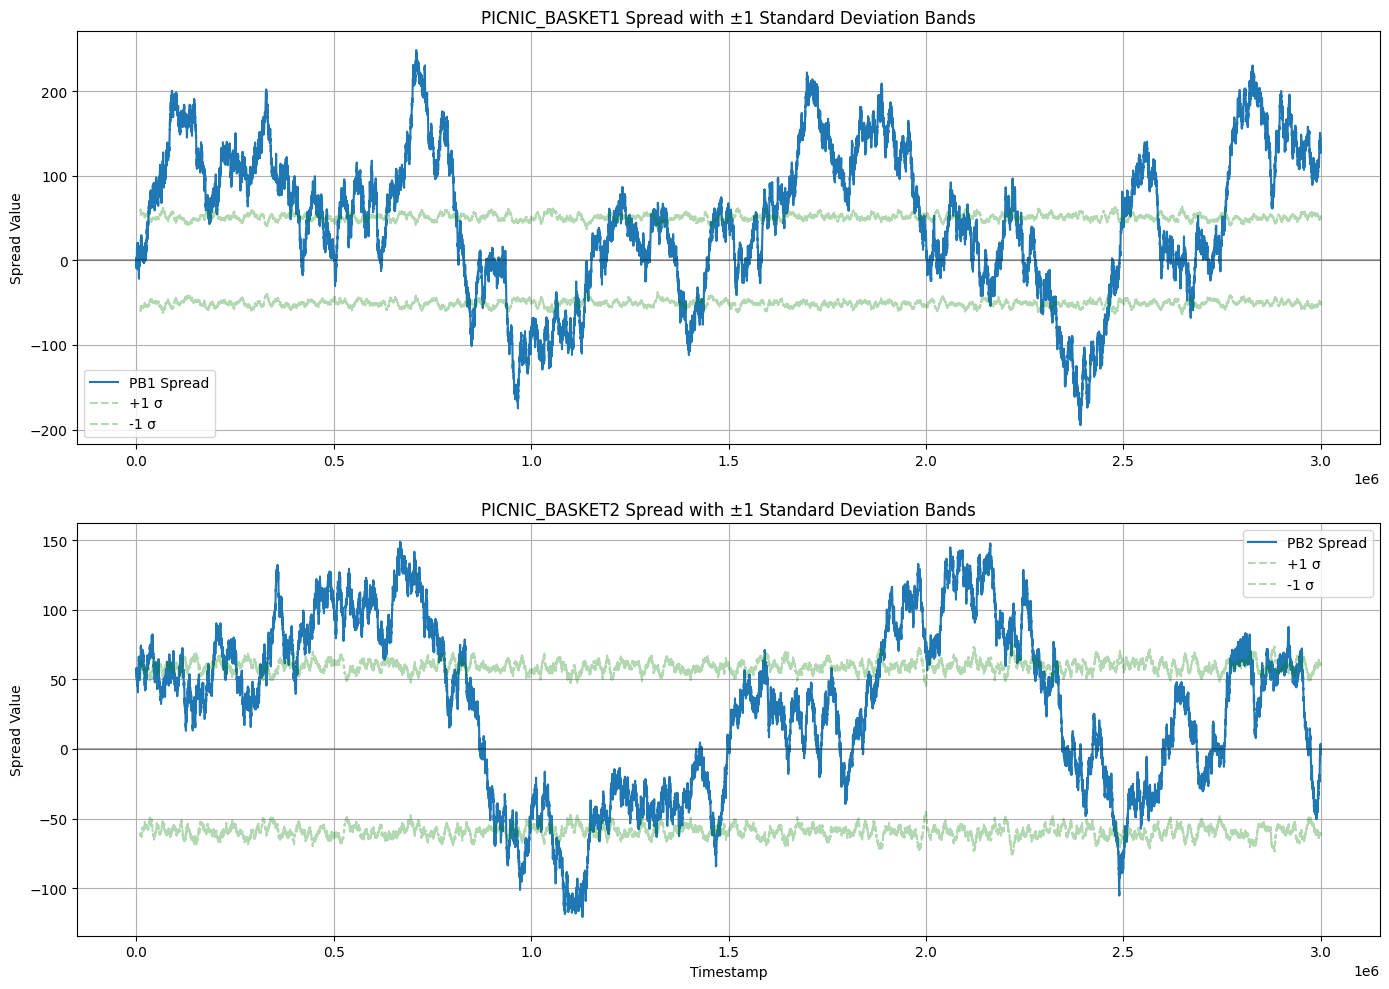

In [26]:
# Calculate z-scores based on rolling std of absolute dollar moves
window = 100  # Standard window size used in other notebooks

# Convert spreads dictionary to DataFrame for easier handling
spread_df = pd.DataFrame({
    'pb1_spread': spreads['pb1_spread'],
    'pb2_spread': spreads['pb2_spread']
})

# Calculate the standard deviation of the price differences
spread_diff_std = spread_df.diff().rolling(window=window).std()

# Plot the spreads with ±1 std dev bands
plt.figure(figsize=(14, 10))

# Plot PB1 spread
plt.subplot(2, 1, 1)
plt.plot(spread_df.index, spread_df['pb1_spread'], label='PB1 Spread')
plt.plot(spread_df.index, 15*spread_diff_std['pb1_spread'], 'g--', label='+1 σ', alpha=0.3)
plt.plot(spread_df.index, -15*spread_diff_std['pb1_spread'], 'g--', label='-1 σ', alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('PICNIC_BASKET1 Spread with ±1 Standard Deviation Bands')
plt.ylabel('Spread Value')
plt.legend()
plt.grid(True)

# Plot PB2 spread
plt.subplot(2, 1, 2)
plt.plot(spread_df.index, spread_df['pb2_spread'], label='PB2 Spread')
plt.plot(spread_df.index, 30*spread_diff_std['pb2_spread'], 'g--', label='+1 σ', alpha=0.3)
plt.plot(spread_df.index, -30*spread_diff_std['pb2_spread'], 'g--', label='-1 σ', alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('PICNIC_BASKET2 Spread with ±1 Standard Deviation Bands')
plt.xlabel('Timestamp')
plt.ylabel('Spread Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Testing strategy combinations...

Testing entry=20.0, exit=0.0

Running pb1_zscore:
Running strategy with entry=20.0, exit=0.0

Running pb2_zscore:
Running strategy with entry=20.0, exit=0.0

Testing entry=20.0, exit=1.0

Running pb1_zscore:
Running strategy with entry=20.0, exit=1.0

Running pb2_zscore:
Running strategy with entry=20.0, exit=1.0

Testing entry=20.0, exit=2.0

Running pb1_zscore:
Running strategy with entry=20.0, exit=2.0

Running pb2_zscore:
Running strategy with entry=20.0, exit=2.0

Testing entry=20.0, exit=3.0

Running pb1_zscore:
Running strategy with entry=20.0, exit=3.0

Running pb2_zscore:
Running strategy with entry=20.0, exit=3.0

Testing entry=20.0, exit=4.0

Running pb1_zscore:
Running strategy with entry=20.0, exit=4.0

Running pb2_zscore:
Running strategy with entry=20.0, exit=4.0

Testing entry=20.0, exit=5.0

Running pb1_zscore:
Running strategy with entry=20.0, exit=5.0

Running pb2_zscore:
Running strategy with entry=20.0, exit=5.0

Testing entry=20.

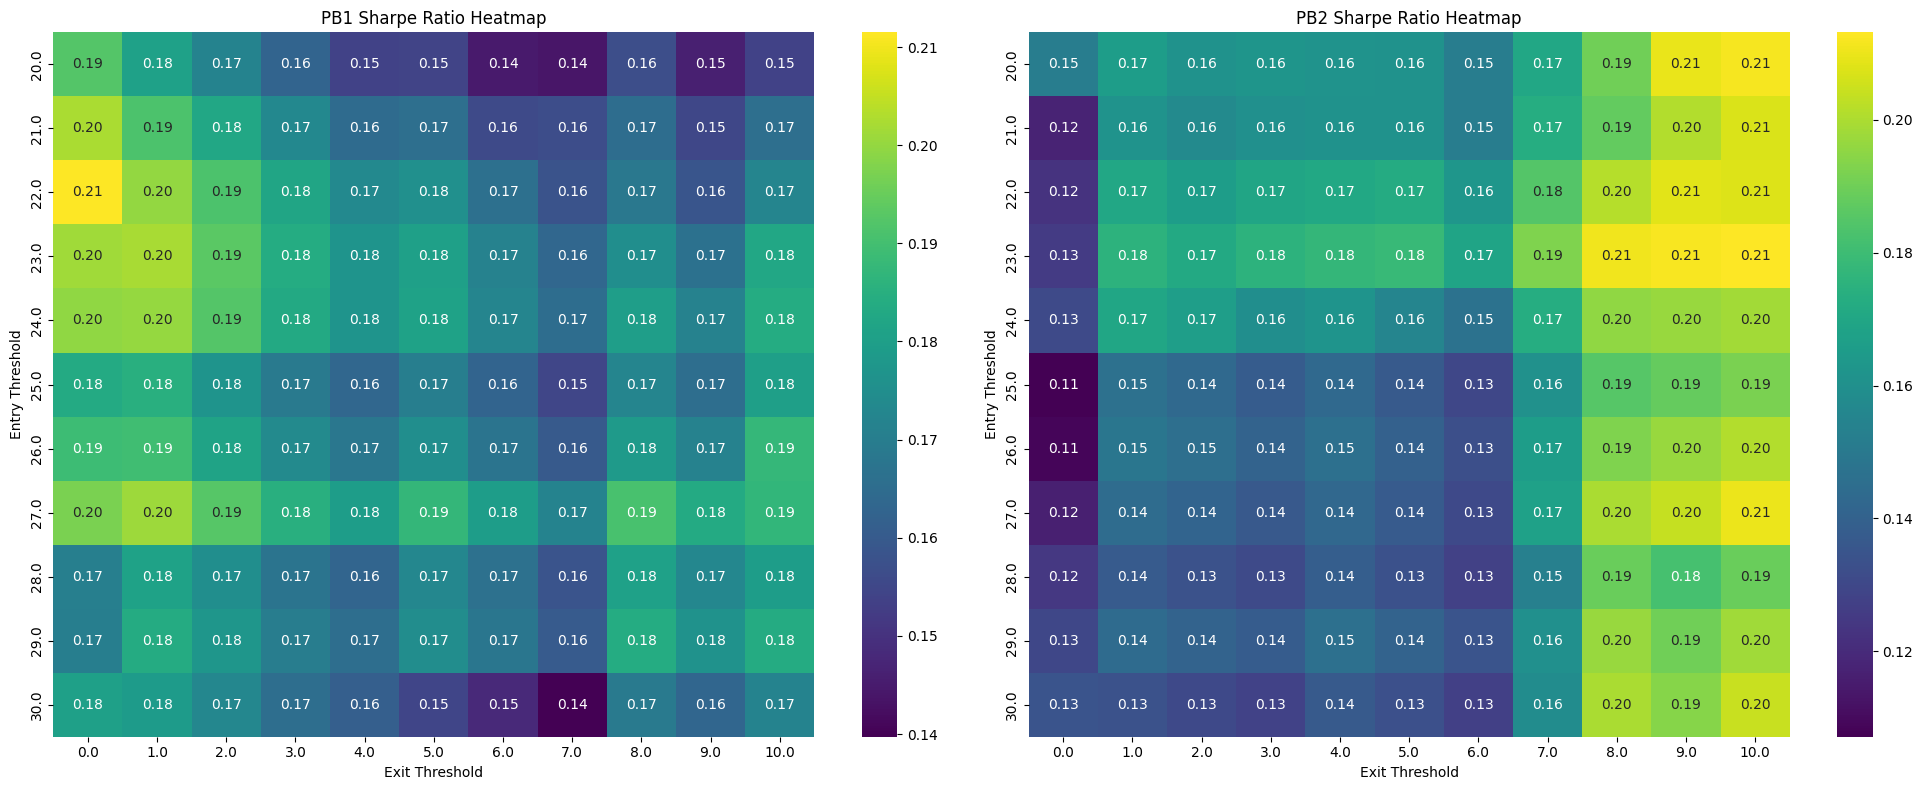


Best Parameters:
PB1: Entry=22.0, Exit=0.0, Sharpe=0.21
PB2: Entry=23.0, Exit=10.0, Sharpe=0.21


In [27]:
import seaborn as sns
# Calculate z-scores based on rolling std of absolute dollar moves
window = 100  # Standard window size

# Calculate absolute dollar moves for each spread
spread_df['pb1_spread_abs_move'] = spread_df['pb1_spread'].diff()
spread_df['pb2_spread_abs_move'] = spread_df['pb2_spread'].diff()

# Calculate rolling standard deviation of absolute dollar moves
spread_df['pb1_spread_roll_std'] = spread_df['pb1_spread_abs_move'].rolling(window=window).std()
spread_df['pb2_spread_roll_std'] = spread_df['pb2_spread_abs_move'].rolling(window=window).std()

# Calculate z-scores
spread_df['pb1_zscore'] = spread_df['pb1_spread'] / spread_df['pb1_spread_roll_std']
spread_df['pb2_zscore'] = spread_df['pb2_spread'] / spread_df['pb2_spread_roll_std']

# Forward fill NaN values in z-scores
spread_df['pb1_zscore'] = spread_df['pb1_zscore'].fillna(0)
spread_df['pb2_zscore'] = spread_df['pb2_zscore'].fillna(0)

def implement_dual_threshold_strategy(spread_df, zscore_col, entry_threshold, exit_threshold):
    """
    Implements a trading strategy with separate entry and exit thresholds.
    Vectorized implementation:
    1. Set -1 for zscores > entry_threshold
    2. Set 1 for zscores < -entry_threshold
    3. Replace 0s with NaN and forward fill
    4. Mask positions to 0 when within exit thresholds
    """
    print(f"Running strategy with entry={entry_threshold}, exit={exit_threshold}")
    
    # Create a copy of the DataFrame to avoid modifying the original
    strategy_df = spread_df.copy()
    
    # Initialize position column
    position_col = f'{zscore_col}_pos_{entry_threshold}_{exit_threshold}'
    
    # Get zscore series
    zscore = strategy_df[zscore_col]
    
    # Create initial positions
    positions = pd.Series(np.nan, index=zscore.index)

    positions[(zscore >= -exit_threshold) & (zscore <= exit_threshold)] = 0
    positions[zscore > entry_threshold] = -1
    positions[zscore < -entry_threshold] = 1

    positions = positions.ffill()
    positions = positions.fillna(0)
    
    # Add positions to strategy DataFrame
    strategy_df[position_col] = positions
    
    # Get the spread column name
    spread_col = zscore_col.replace('_zscore', '_spread')
    
    # Calculate returns
    strategy_df[f'{spread_col}_return'] = (strategy_df[spread_col]).diff()
    strategy_df[f'{position_col}_return'] = strategy_df[position_col].shift(1) * strategy_df[f'{spread_col}_return']
    strategy_df[f'{position_col}_return'] = strategy_df[f'{position_col}_return'].fillna(0)
    strategy_df[f'{position_col}_cum_return'] = strategy_df[f'{position_col}_return'].cumsum()
    
    return strategy_df

print("\nTesting strategy combinations...")

# Create denser threshold combinations
entry_thresholds = np.linspace(20, 30, 11)  # 11 points between 20 and 30
exit_thresholds = np.linspace(0, 10, 11)    # 11 points between 0 and 10

# Initialize results dictionary for heatmap
heatmap_results_pb1 = np.zeros((len(entry_thresholds), len(exit_thresholds)))
heatmap_results_pb2 = np.zeros((len(entry_thresholds), len(exit_thresholds)))

# Test different threshold combinations
for i, entry_thresh in enumerate(entry_thresholds):
    for j, exit_thresh in enumerate(exit_thresholds):
        if exit_thresh >= entry_thresh:
            heatmap_results_pb1[i, j] = np.nan
            heatmap_results_pb2[i, j] = np.nan
            continue
            
        print(f"\nTesting entry={entry_thresh:.1f}, exit={exit_thresh:.1f}")
        
        # Run strategy for both PB1 and PB2
        for zscore_col in ['pb1_zscore', 'pb2_zscore']:
            print(f"\nRunning {zscore_col}:")
            strategy_results = implement_dual_threshold_strategy(
                spread_df, 
                zscore_col, 
                entry_thresh, 
                exit_thresh
            )
            
            # Calculate Sharpe Ratio
            pos_col = f'{zscore_col}_pos_{entry_thresh:.1f}_{exit_thresh:.1f}'
            ret_col = f'{pos_col}_return'
            returns = strategy_results[ret_col]
            sharpe = np.sqrt(252) * returns.mean() / returns.std() if returns.std() != 0 else 0
            
            # Store results in appropriate heatmap array
            if zscore_col == 'pb1_zscore':
                heatmap_results_pb1[i, j] = sharpe
            else:
                heatmap_results_pb2[i, j] = sharpe

# Plot heatmaps
plt.figure(figsize=(20, 8))

# PB1 Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(heatmap_results_pb1, 
            xticklabels=[f'{x:.1f}' for x in exit_thresholds],
            yticklabels=[f'{x:.1f}' for x in entry_thresholds],
            cmap='viridis',
            annot=True,
            fmt='.2f',
            mask=np.isnan(heatmap_results_pb1))
plt.title('PB1 Sharpe Ratio Heatmap')
plt.xlabel('Exit Threshold')
plt.ylabel('Entry Threshold')

# PB2 Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(heatmap_results_pb2,
            xticklabels=[f'{x:.1f}' for x in exit_thresholds],
            yticklabels=[f'{x:.1f}' for x in entry_thresholds],
            cmap='viridis',
            annot=True,
            fmt='.2f',
            mask=np.isnan(heatmap_results_pb2))
plt.title('PB2 Sharpe Ratio Heatmap')
plt.xlabel('Exit Threshold')
plt.ylabel('Entry Threshold')

plt.tight_layout()
plt.show()

# Find and print best parameters
best_pb1_idx = np.unravel_index(np.nanargmax(heatmap_results_pb1), heatmap_results_pb1.shape)
best_pb2_idx = np.unravel_index(np.nanargmax(heatmap_results_pb2), heatmap_results_pb2.shape)

print("\nBest Parameters:")
print(f"PB1: Entry={entry_thresholds[best_pb1_idx[0]]:.1f}, "
      f"Exit={exit_thresholds[best_pb1_idx[1]]:.1f}, "
      f"Sharpe={heatmap_results_pb1[best_pb1_idx]:.2f}")
print(f"PB2: Entry={entry_thresholds[best_pb2_idx[0]]:.1f}, "
      f"Exit={exit_thresholds[best_pb2_idx[1]]:.1f}, "
      f"Sharpe={heatmap_results_pb2[best_pb2_idx]:.2f}")

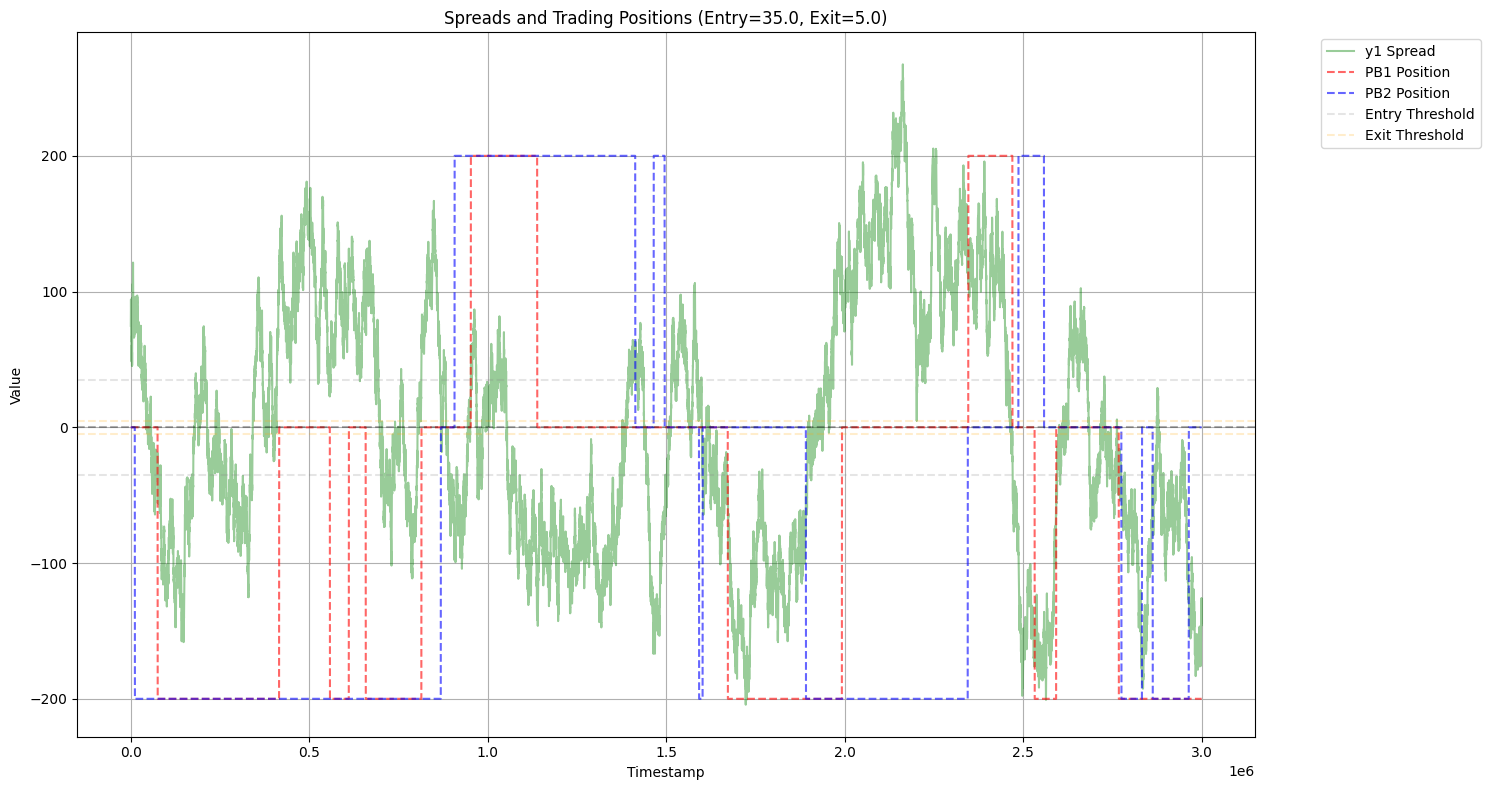


PB1 Position Statistics:
Average Position: -56.8133
Position Standard Deviation: 128.0291
Number of Position Changes: 15
Maximum Position: 200.0000
Minimum Position: -200.0000

PB1 Position Distribution:
Position -200.0: 11618 occurrences (38.73% of time)
Position 0.0: 15286 occurrences (50.95% of time)
Position 200.0: 3096 occurrences (10.32% of time)

PB2 Position Statistics:
Average Position: -58.0600
Position Standard Deviation: 156.4327
Number of Position Changes: 16
Maximum Position: 200.0000
Minimum Position: -200.0000

PB2 Position Distribution:
Position -200.0: 14795 occurrences (49.32% of time)
Position 0.0: 9119 occurrences (30.40% of time)
Position 200.0: 6086 occurrences (20.29% of time)

Custom Position Statistics:
Average Position: 2.1000
Position Standard Deviation: 136.5877
Number of Position Changes: 25
Maximum Position: 200.0000
Minimum Position: -200.0000

Custom Position Distribution:
Position -200.0: 6840 occurrences (22.80% of time)
Position 0.0: 16005 occurrenc

In [46]:
# Calculate spreads
pb1_spread = reindexed_prices['PICNIC_BASKET1'] - theoretical_pb1
pb2_spread = reindexed_prices['PICNIC_BASKET2'] - theoretical_pb2
custom_spread = 1.5*reindexed_prices['PICNIC_BASKET2'] + reindexed_prices['DJEMBES'] - reindexed_prices['PICNIC_BASKET1']
log_custom_spread = np.log(1.5*reindexed_prices['PICNIC_BASKET2'] + reindexed_prices['DJEMBES']) - np.log(reindexed_prices['PICNIC_BASKET1'])

# Calculate positions based on z-score of the spread (vectorized)
def calculate_positions(spread, entry_threshold=2.0, exit_threshold=1.0, window=100):
    """
    Implements a trading strategy with separate entry and exit thresholds.
    Vectorized implementation:
    1. Set -1 for zscores > entry_threshold
    2. Set 1 for zscores < -entry_threshold
    3. Replace 0s with NaN and forward fill
    4. Mask positions to 0 when within exit thresholds
    """
    # Calculate z-score
    rolling_std = spread.diff().rolling(window=window).std()
    z_score = spread / rolling_std
    
    # Create initial positions
    positions = pd.Series(np.nan, index=z_score.index)
    positions[(z_score >= -exit_threshold) & (z_score <= exit_threshold)] = 0
    positions[z_score > entry_threshold] = -200
    positions[z_score < -entry_threshold] = 200
    
    # Replace 0s with NaN and forward fill
    positions = positions.ffill()
    
    # Fill any remaining NaNs with 0
    positions = positions.fillna(0)
    
    return positions, z_score

# Calculate positions with dual thresholds
entry_threshold = 35.0  # Higher threshold for entry
exit_threshold = 5.0    # Lower threshold for exit

# Calculate positions for all three spreads
pb1_positions, pb1_zscore = calculate_positions(pb1_spread, entry_threshold, exit_threshold)
pb2_positions, pb2_zscore = calculate_positions(pb2_spread, entry_threshold, exit_threshold)
custom_positions, custom_zscore = calculate_positions(custom_spread, entry_threshold, exit_threshold)

# Create the visualization (single plot)
plt.figure(figsize=(15, 8))

# Plot spreads (normalized for comparison)
# plt.plot(pb1_spread, label='PB1 Spread (normalized)', color='red', alpha=0.3)
# plt.plot(pb2_spread, label='PB2 Spread (normalized)', color='blue', alpha=0.3)
plt.plot(custom_spread, label='y1 Spread', color='green', alpha=0.4)

# Plot positions
plt.plot(pb1_positions, label='PB1 Position', color='red', linestyle='--', alpha=0.6)
plt.plot(pb2_positions, label='PB2 Position', color='blue', linestyle='--', alpha=0.6)
# plt.plot(custom_positions, label='Custom Position', color='green', linestyle='--', alpha=0.6)

# Add horizontal lines for entry and exit thresholds
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.axhline(y=entry_threshold, color='gray', linestyle='--', alpha=0.2, label='Entry Threshold')
plt.axhline(y=-entry_threshold, color='gray', linestyle='--', alpha=0.2)
plt.axhline(y=exit_threshold, color='orange', linestyle='--', alpha=0.2, label='Exit Threshold')
plt.axhline(y=-exit_threshold, color='orange', linestyle='--', alpha=0.2)

plt.title(f'Spreads and Trading Positions (Entry={entry_threshold}, Exit={exit_threshold})')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print position statistics for all strategies
for name, positions in [('PB1', pb1_positions), ('PB2', pb2_positions), ('Custom', custom_positions)]:
    position_changes = positions.diff().abs() > 0
    print(f"\n{name} Position Statistics:")
    print(f"Average Position: {positions.mean():.4f}")
    print(f"Position Standard Deviation: {positions.std():.4f}")
    print(f"Number of Position Changes: {position_changes.sum()}")
    print(f"Maximum Position: {positions.max():.4f}")
    print(f"Minimum Position: {positions.min():.4f}")
    
    # Calculate position distribution
    position_dist = positions.value_counts().sort_index()
    print(f"\n{name} Position Distribution:")
    for pos, count in position_dist.items():
        percentage = (count / len(positions)) * 100
        print(f"Position {pos}: {count} occurrences ({percentage:.2f}% of time)")

# Print z-score statistics for all strategies
for name, zscore in [('PB1', pb1_zscore), ('PB2', pb2_zscore), ('Custom', custom_zscore)]:
    print(f"\n{name} Z-Score Statistics:")
    print(f"Average Z-Score: {zscore.mean():.4f}")
    print(f"Z-Score Standard Deviation: {zscore.std():.4f}")
    print(f"Maximum Z-Score: {zscore.max():.4f}")
    print(f"Minimum Z-Score: {zscore.min():.4f}")

<Axes: xlabel='timestamp'>

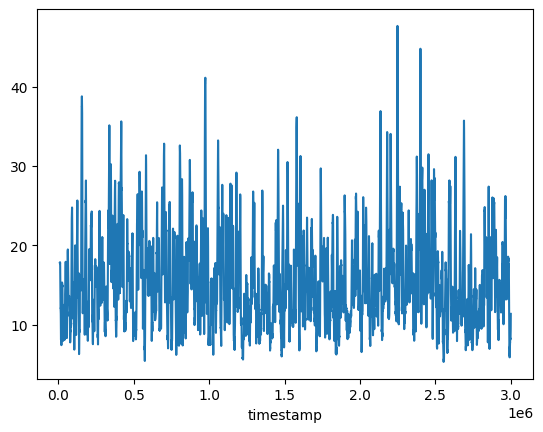

In [29]:
custom_spread.rolling(100).std().plot()

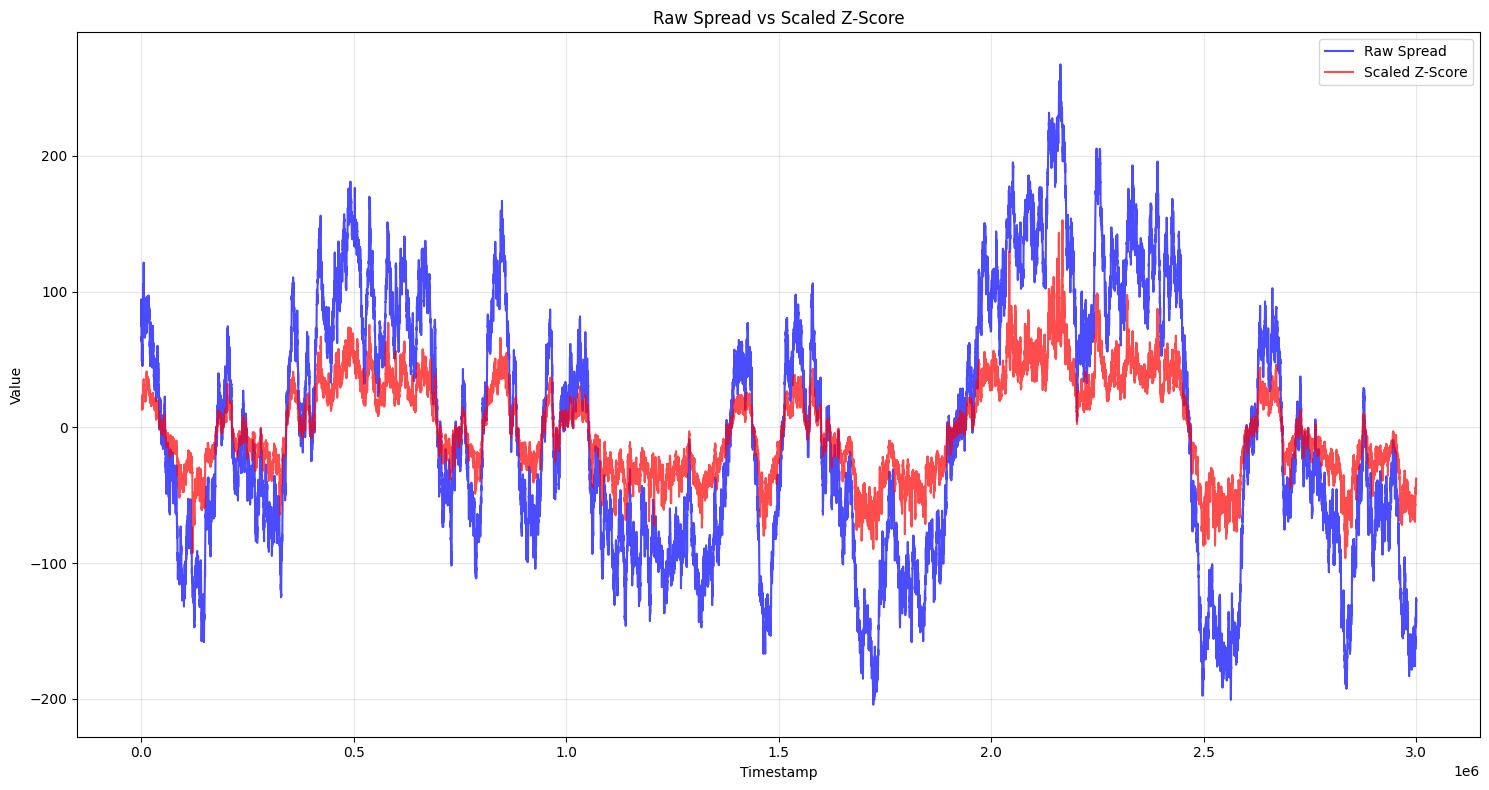


Statistics:
Raw Spread Std: 93.50
Scaled Z-Score Std: 34.22

Correlation between measures: 0.98


In [45]:
# Calculate rolling standard deviation and z-score
window = 20
rolling_std = custom_spread.diff().rolling(window=window).std()
zscore = custom_spread / rolling_std/ np.sqrt(window)

# Scale z-score to match spread scale by multiplying by sqrt(window)
scaled_zscore = zscore * window/3

# Create single plot with both series
plt.figure(figsize=(15, 8))

# Plot both series
plt.plot(custom_spread, color='blue', label='Raw Spread', alpha=0.7)
plt.plot(scaled_zscore, color='red', label='Scaled Z-Score', alpha=0.7)

plt.title('Raw Spread vs Scaled Z-Score')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
print("\nStatistics:")
print(f"Raw Spread Std: {custom_spread.std():.2f}")
print(f"Scaled Z-Score Std: {scaled_zscore.std():.2f}")
print(f"\nCorrelation between measures: {custom_spread.corr(scaled_zscore):.2f}")

<Axes: xlabel='timestamp'>

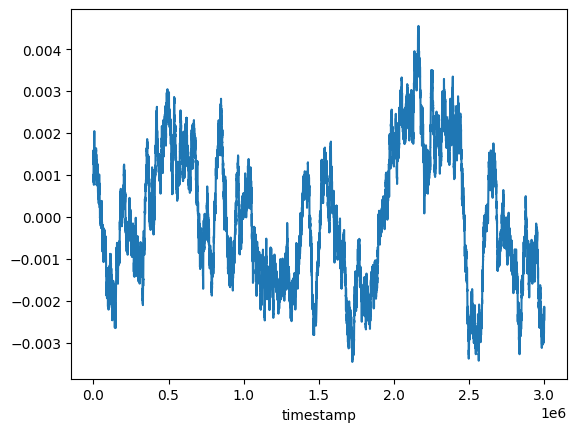

In [ ]:
window = 50
sns.lineplot(data=log_custom_spread)
log_custom_spread


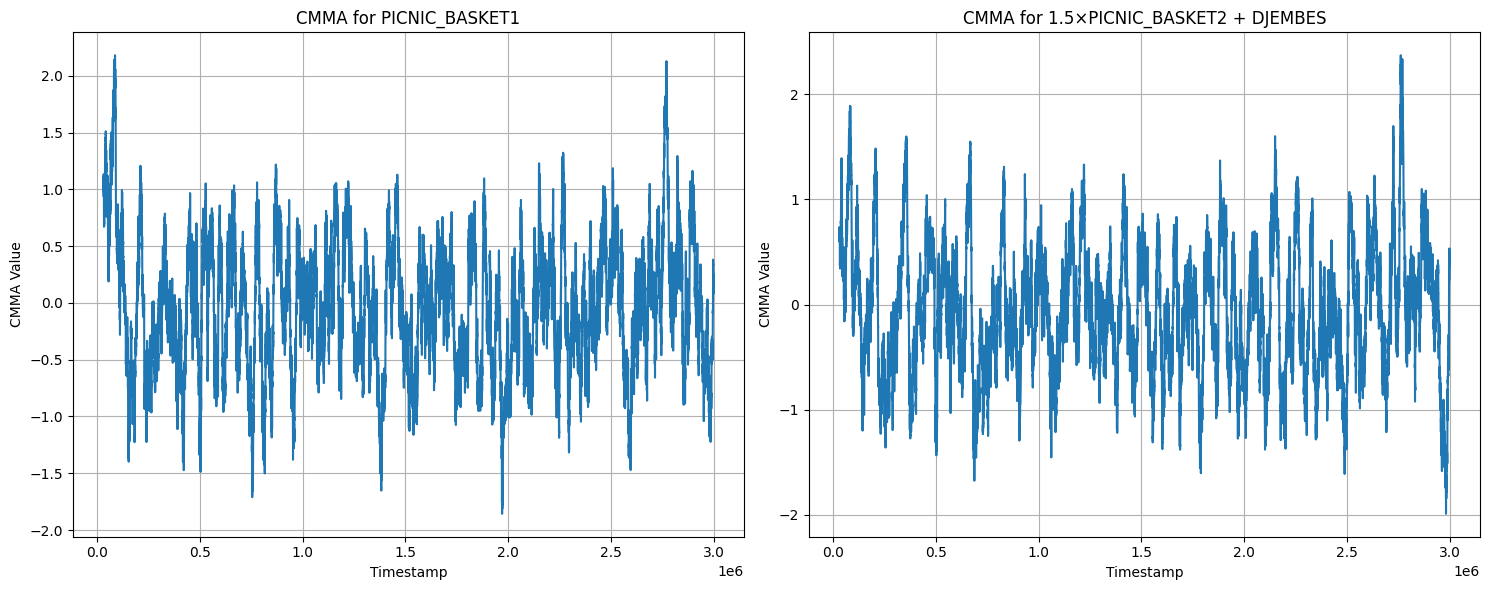

In [56]:
np.log(1.5*reindexed_prices['PICNIC_BASKET2'] + reindexed_prices['DJEMBES']) - np.log(reindexed_prices['PICNIC_BASKET1'])
def cmma (log_prices, lookback=100, atr_lookback=200):
    atr = log_prices.diff().rolling(atr_lookback).std()
    raw_cmma = (log_prices - log_prices.rolling(lookback).mean().shift(1)).divide(atr*np.sqrt(lookback+1)).dropna()
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    return (raw_cmma)

log_pb1 = np.log(reindexed_prices['PICNIC_BASKET1'])
log_pb2dj = np.log(1.5*reindexed_prices['PICNIC_BASKET2'] + reindexed_prices['DJEMBES'])
# Create side-by-side CMMA plots
plt.figure(figsize=(15, 6))

# Plot CMMA for PB1
plt.subplot(1, 2, 1)
cmma(log_pb1, 300, 300).plot()
plt.title('CMMA for PICNIC_BASKET1')
plt.xlabel('Timestamp')
plt.ylabel('CMMA Value')
plt.grid(True)

# Plot CMMA for PB2+DJEMBES
plt.subplot(1, 2, 2)
cmma(log_pb2dj, 300, 300).plot()
plt.title('CMMA for 1.5×PICNIC_BASKET2 + DJEMBES')
plt.xlabel('Timestamp')
plt.ylabel('CMMA Value')
plt.grid(True)

plt.tight_layout()
plt.show()

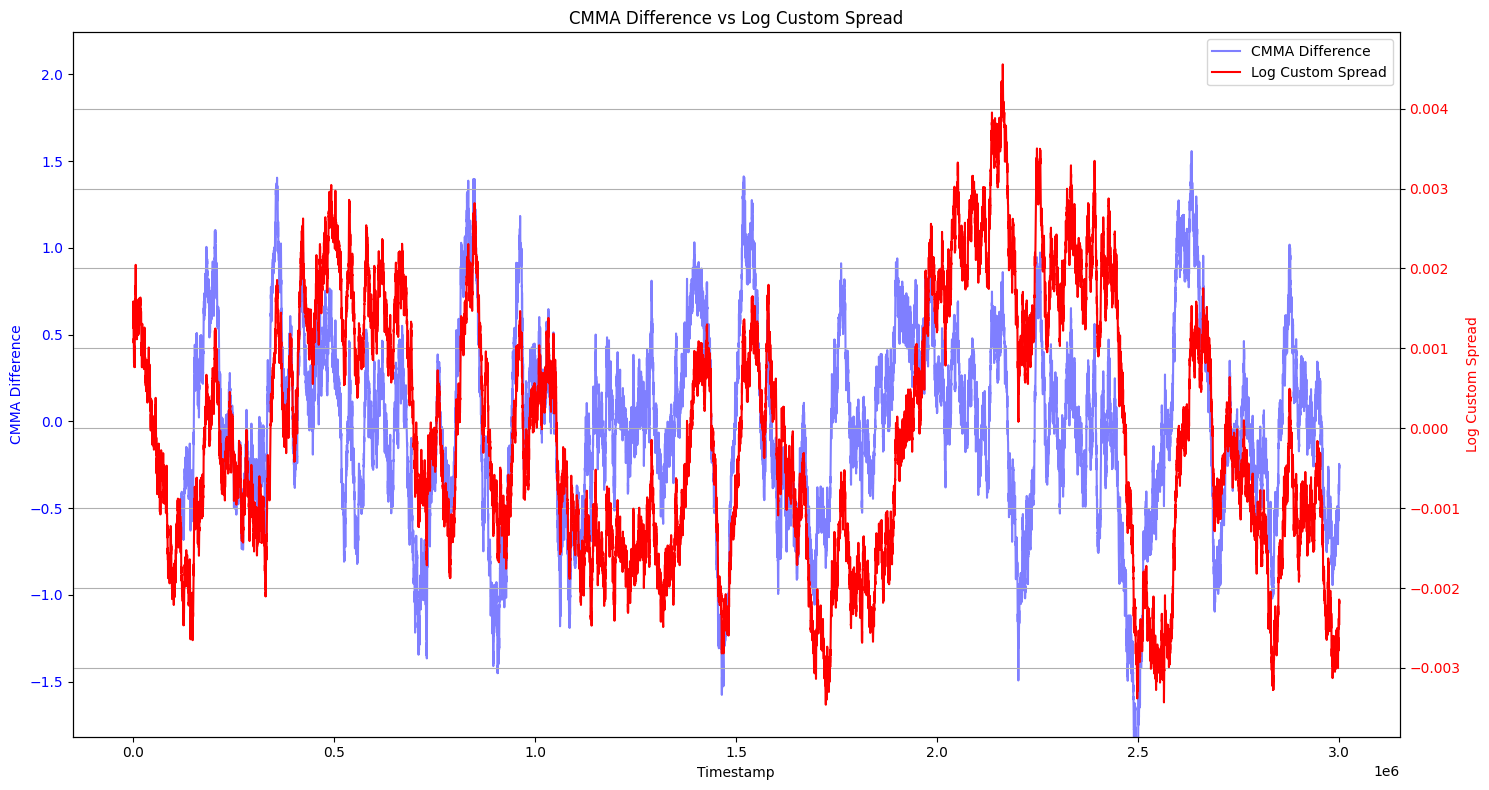


Correlation between CMMA difference and log custom spread: 0.485


In [83]:
# Calculate CMMA difference
cmma_difference = cmma(log_pb2dj, 800, 1200)-cmma(log_pb1, 800, 1200)

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot CMMA difference on primary y-axis
color1 = 'blue'
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('CMMA Difference', color=color1)
line1 = ax1.plot(cmma_difference, alpha = 0.5, color=color1, label='CMMA Difference')
ax1.tick_params(axis='y', labelcolor=color1)

# Set y-axis limits for the CMMA difference (adjust these values to move the blue line)
current_ymin, current_ymax = ax1.get_ylim()
ax1.set_ylim(current_ymin + 0.5, current_ymax + 0.5)  # Adjust these offsets to move the line

# Create secondary y-axis and plot custom spread
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('Log Custom Spread', color=color2)
line2 = ax2.plot(log_custom_spread, color=color2, label='Log Custom Spread')
ax2.tick_params(axis='y', labelcolor=color2)

# Combine lines for legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('CMMA Difference vs Log Custom Spread')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print correlation
correlation = cmma_difference.corr(log_custom_spread)
print(f"\nCorrelation between CMMA difference and log custom spread: {correlation:.3f}")